# Here we start Task 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import pickle
import openpyxl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme()
plt.rcParams["figure.figsize"] = (10,6)

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_text
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import label_binarize
from sklearn import svm

# Dataset loading and adjusting

In [2]:
final_df = pd.read_excel('data/final_tm_df_15.xlsx')
del final_df['LDA_15']
del final_df['Author']
del final_df['Party']
del final_df['Original_tweet']

### Sets split

In [3]:
from sklearn.model_selection import train_test_split

#we separate our data into training and test
df_test, df_train = train_test_split(final_df, test_size=0.7, random_state=420)

df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=420)

T_train = df_train['Main_topic']
Y_train = df_train['Mayor Parties']
X_train = np.array(df_train.drop(['Main_topic','Mayor Parties'],axis =1))


T_test = df_test['Main_topic']
Y_test = df_test['Mayor Parties']
X_test = np.array(df_test.drop(['Main_topic','Mayor Parties'],axis =1))

T_val = df_val['Main_topic']
Y_val = df_val['Mayor Parties']
X_val = np.array(df_val.drop(['Main_topic','Mayor Parties'],axis =1))

print(f"Len train: {len(X_train)}")
print(f"Len test: {len(X_test)}")
print(f"Len validation: {len(X_val)}")

Len train: 8515
Len test: 1824
Len validation: 1825


### Scaling the data

In [4]:
from sklearn.preprocessing import StandardScaler

#we will first scale our data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Data dimensionality reduction

### Visualizing our data to identify features and clusters

#### Principal Component Analysis visualization

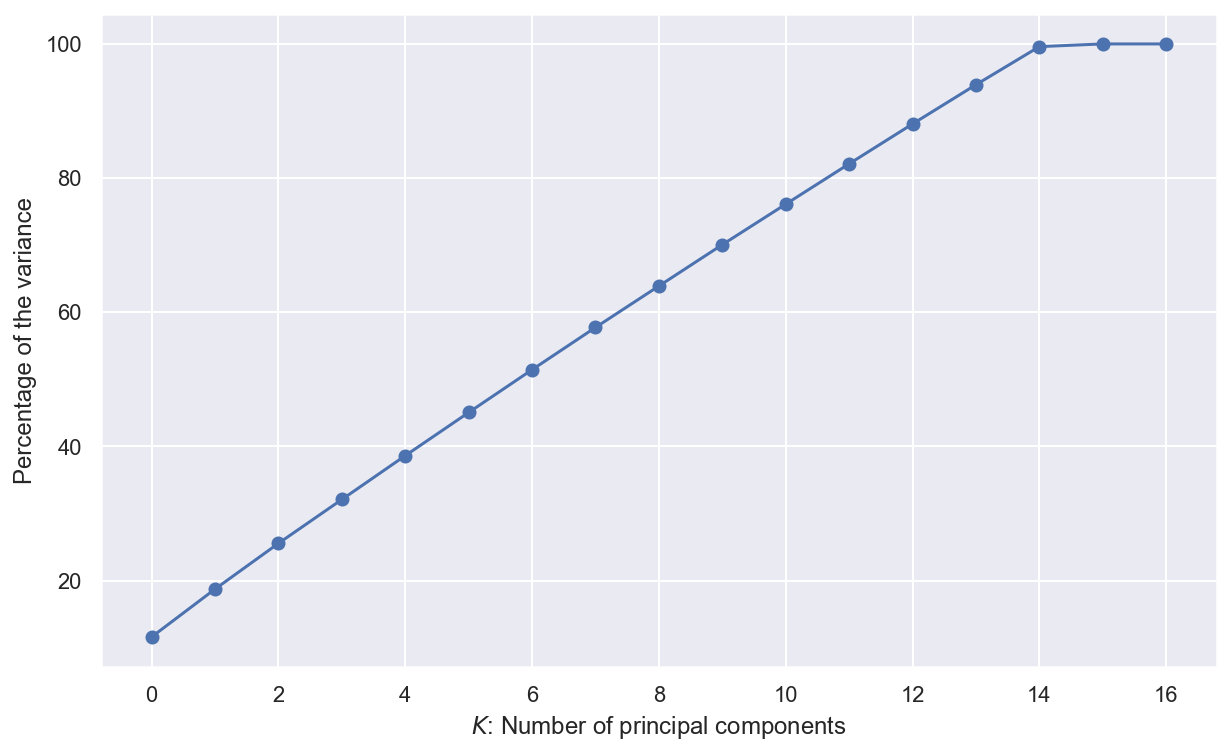

In [5]:
from sklearn.decomposition import PCA

#we check how some dimensionality reduction techniques work
pca = PCA(n_components=X_train.shape[1]).fit(X_train)
eigenvalues = pca.explained_variance_

data_variance = np.sum(np.var(X_train,0))

plt.figure()
plt.plot(100*np.cumsum(eigenvalues)/data_variance, 'o-', label='Evolution eigenvalues')
plt.xlabel('$K$: Number of principal components')
plt.ylabel('Percentage of the variance')
plt.show()

#Most of the variance is explained by most of the components except the last two and the ammount of 
# variance explained by each of these other components is almost the same
# As we have very few variables a dimensionality reduction technique might not be very convenient.
# These two reasons make for our decision of not

In [6]:
#We are still going to plot the two most relevant dimensions of the PCA transformed data 
#to see if we can identify some 

In [7]:
color_assign = {
    'Vox':sns.color_palette()[2], 
    'PP':sns.color_palette()[0],
    'PSOE':sns.color_palette()[3], 
    'Unidas Podemos':sns.color_palette()[4], 
    'Ciudadanos':sns.color_palette()[1],
    'Other':sns.color_palette()[7]
}

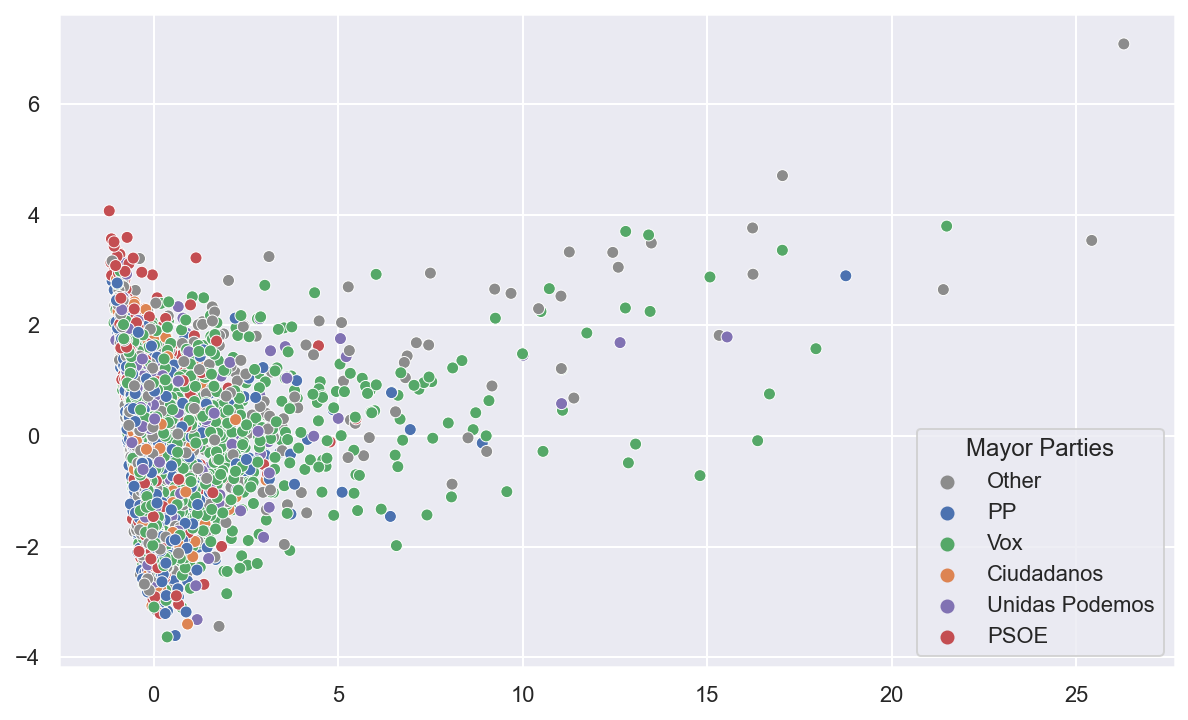

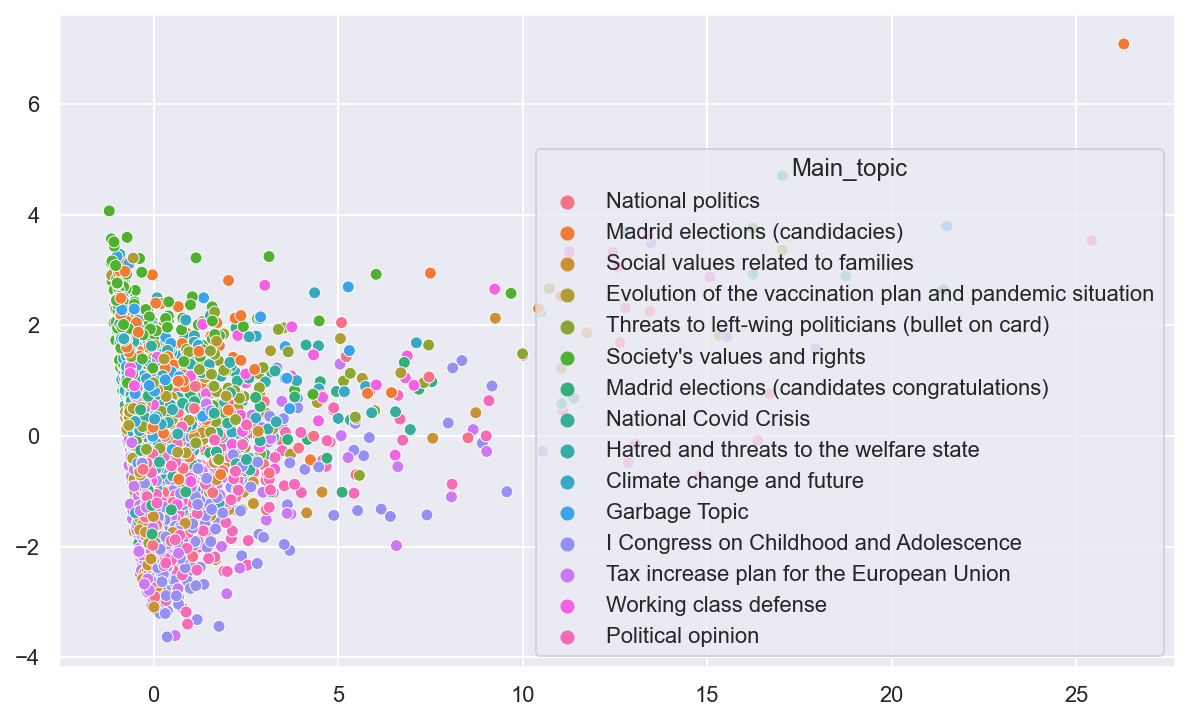

In [8]:
p_train = pca.transform(X_train)
plt.figure()
sns.scatterplot(x = p_train[:,0], 
                y = p_train[:,1], 
                hue = Y_train, 
                palette=color_assign)
plt.figure()
sns.scatterplot(x = p_train[:,0], 
                y = p_train[:,1], 
                hue = T_train)
plt.show()

#### T-Distributed Stochastic Neighbor Embedding visualization

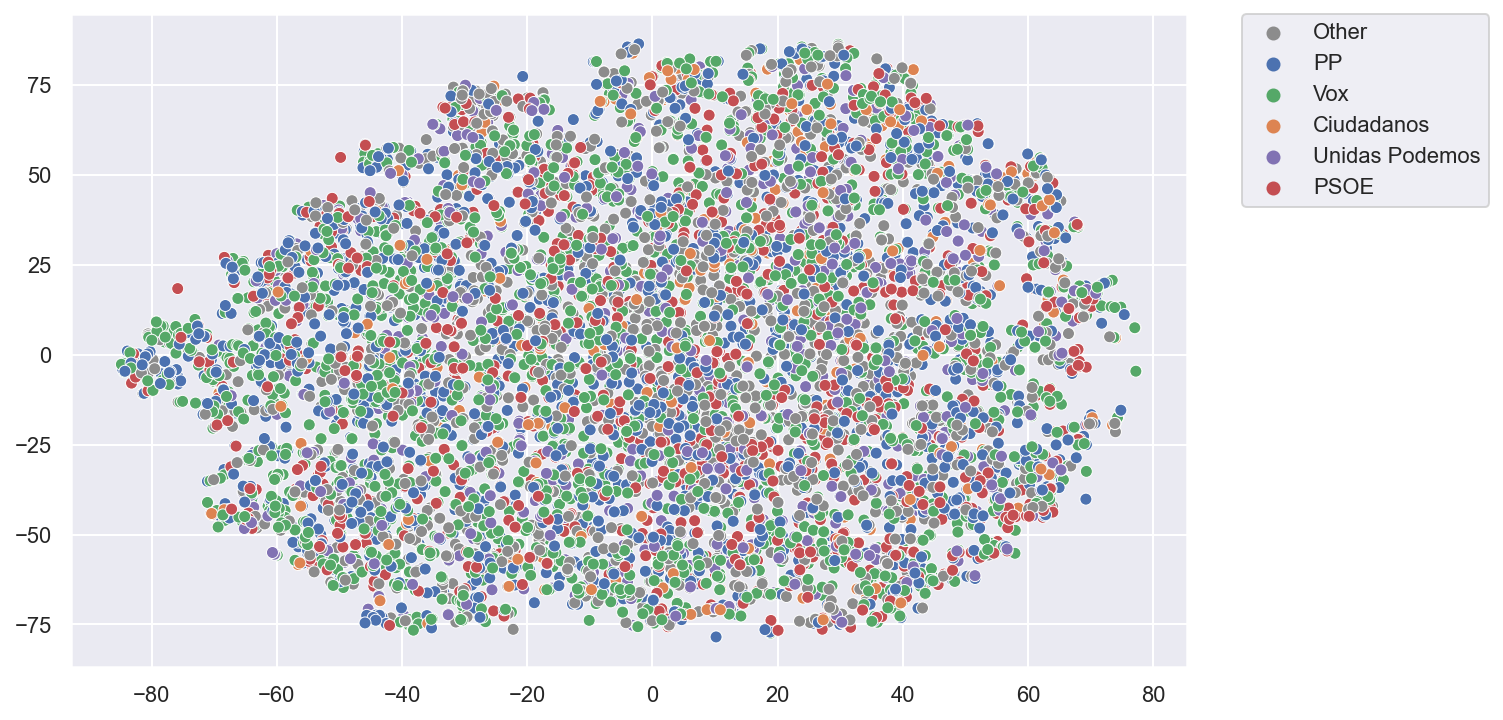

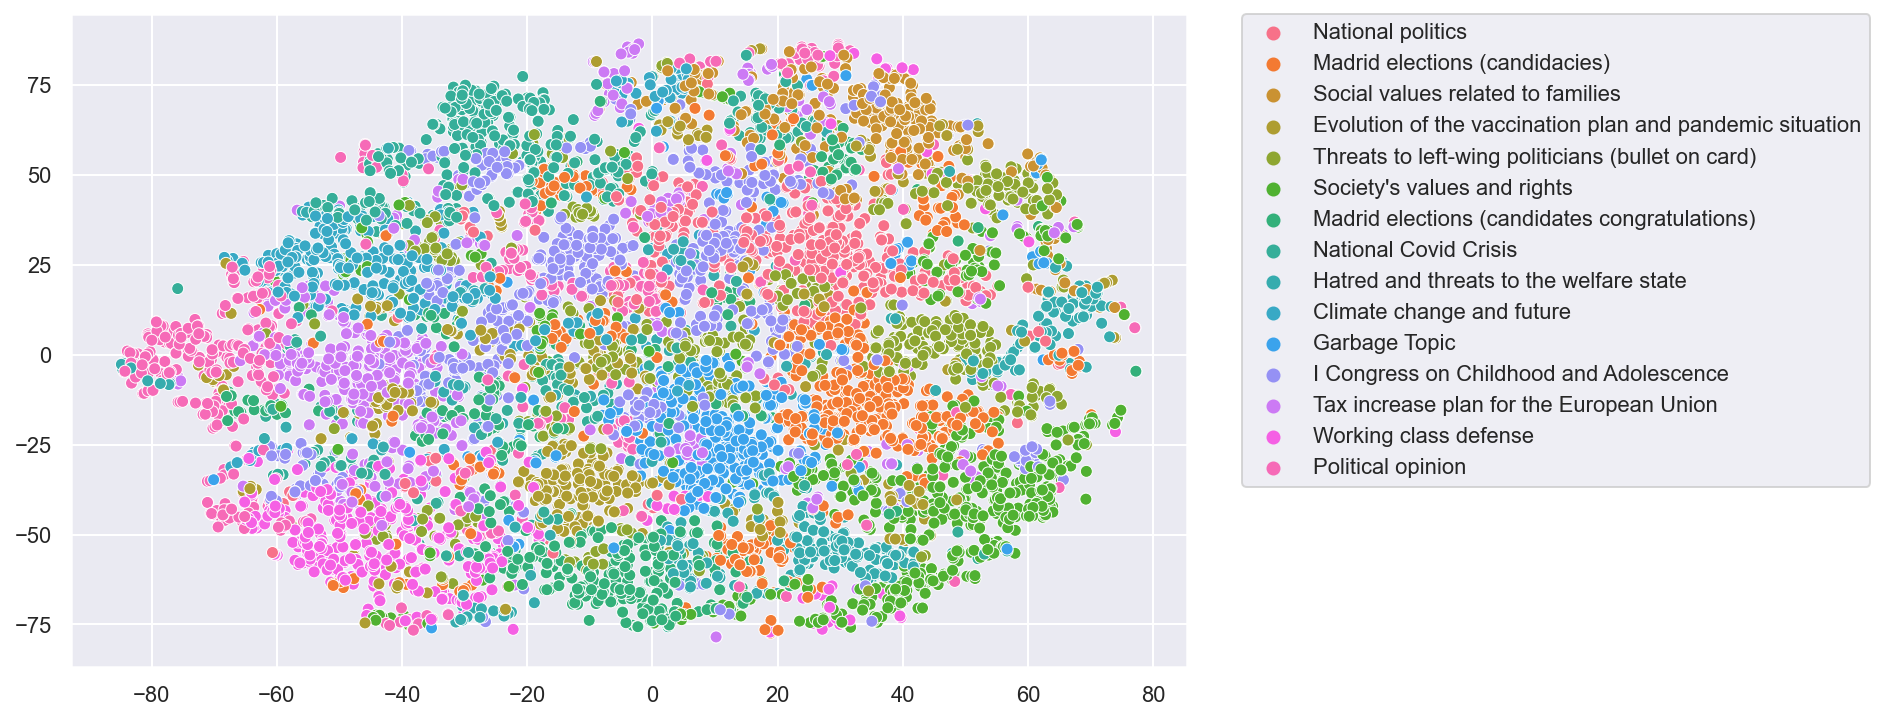

In [9]:
from sklearn.manifold import TSNE

p_train = TSNE(n_components=2).fit_transform(X_train[:,:-2]) 
#plot the two components of the tsne without the likes and retweets

plt.figure()
sns.scatterplot(x = p_train[:,0], 
                y = p_train[:,1], 
                hue = Y_train,
                palette=color_assign)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure() 
sns.scatterplot(x = p_train[:,0], 
                y = p_train[:,1], 
                hue = T_train)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Checking the accuracy with SVM

#### Defining our evaluating function

In [10]:
from sklearn import svm

def SVM_accuracy_evolution(X_train_t, Y_train, X_val_t, Y_val, X_test_t, Y_test, rang_feat):
    """Compute the accuracy of training, validation and test data for different the number of features

    Args:
        X_train_t (numpy dnarray): training data projected in the new feature space (number data x number dimensions).
        Y_train (numpy dnarray): labels of the training data (number data x 1).
        X_val_t (numpy dnarray): validation data projected in the new feature space (number data x number dimensions).
        Y_val (numpy dnarray): labels of the validation data (number data x 1).
        X_test_t (numpy dnarray): test data projected in the new feature space (number data x number dimensions).
        Y_test (numpy dnarray): labels of the test data (number data x 1).                                     
        rang_feat: range with different number of features to be evaluated 
    """
    
    # Define the model to train a liner SVM
    clf = svm.SVC(kernel='linear')
    
    acc_tr = np.empty(X_train_t.shape[1]-1)
    acc_val = np.empty(X_train_t.shape[1]-1)
    acc_test = np.empty(X_train_t.shape[1]-1)
    for i in rang_feat:
        # Train SVM classifier
        clf.fit(X_train_t[:,:i], Y_train)

        # Compute train, val and test accuracies and save in acc_tr, acc_val and acc_test
        acc_tr[i-1] =  clf.score(X_train_t[:,:i], Y_train)
        acc_val[i-1] = clf.score(X_val_t[:,:i], Y_val)
        acc_test[i-1] = clf.score(X_test_t[:,:i], Y_test)

    return acc_tr, acc_val,acc_test

#### Evaluating PCA

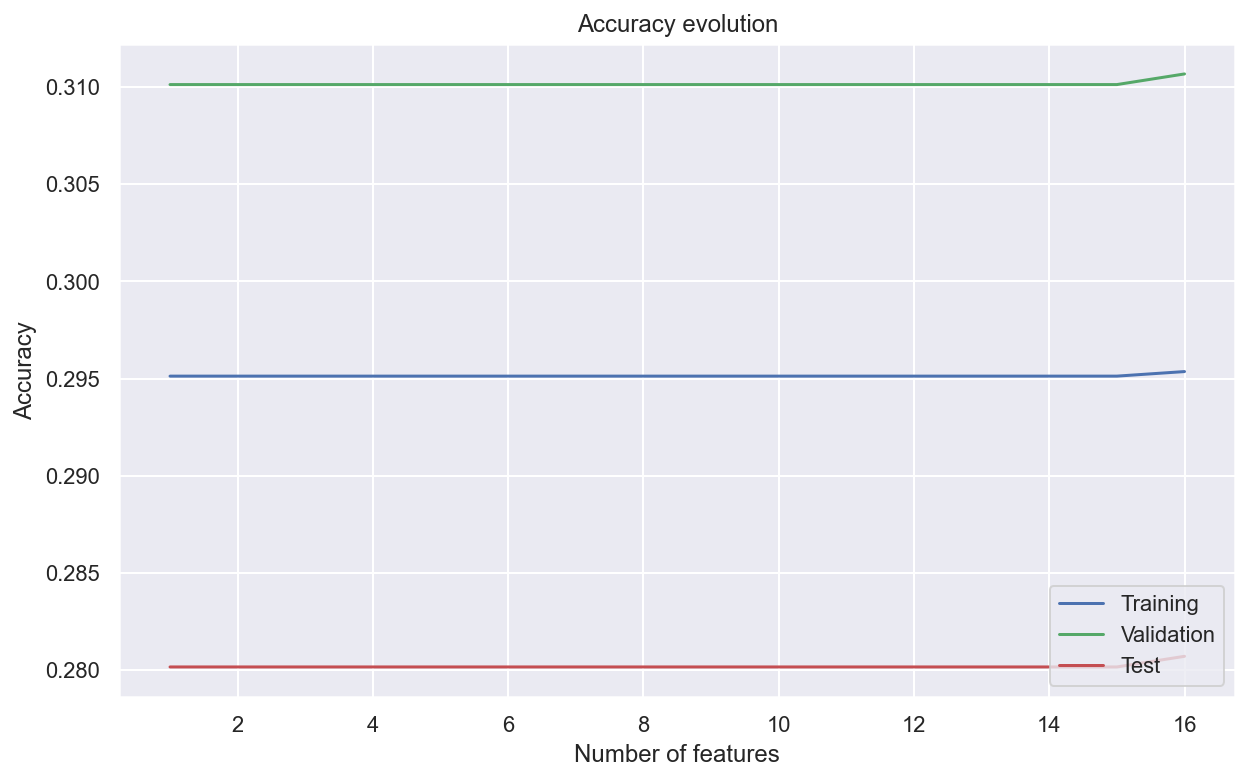

In [11]:
P_train = pca.transform(X_train)
P_test = pca.transform(X_test)
P_val = pca.transform(X_val)
N_feat_max = X_train.shape[1]

rang_feat = np.arange(1, N_feat_max, 1)
[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(P_train, 
                                                     Y_train, 
                                                     P_val, 
                                                     Y_val, 
                                                     P_test,
                                                     Y_test, rang_feat)

plt.figure()
plt.plot(rang_feat, acc_tr, "b", label="train")
plt.plot(rang_feat, acc_val, "g", label="val")
plt.plot(rang_feat, acc_test, "r", label="test")

plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title('Accuracy evolution')
plt.legend(['Training', 'Validation', 'Test'], loc = 4)
plt.show()

#### Evaluating CCA 

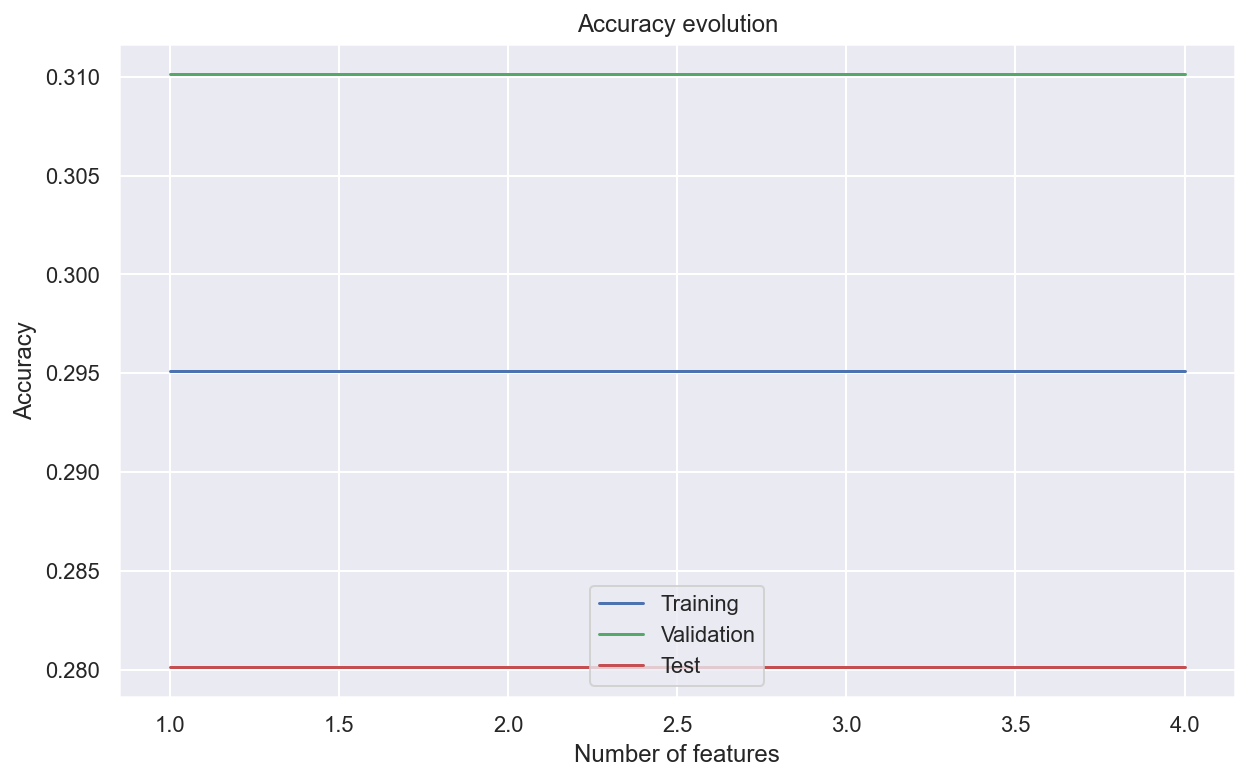

Number optimum of features: 1
The optimum test accuracy is 28.015350877192986


In [12]:
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import label_binarize
Y_train_bin = label_binarize(Y_train, classes=list(Y_train.unique()))
N_feat_max = Y_train.unique().size-1
cca = CCA(n_components=N_feat_max)
cca.fit(X_train, Y_train_bin)

P_train_cca = cca.transform(X_train)
P_test_cca = cca.transform(X_test)
P_val_cca = cca.transform(X_val)

rang_feat = np.arange(1, N_feat_max, 1)
[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(P_train_cca, 
                                                     Y_train, 
                                                     P_val_cca, 
                                                     Y_val, 
                                                     P_test_cca,
                                                     Y_test, rang_feat)

plt.figure()
plt.plot(range(1, P_train_cca.shape[1]), acc_tr, "b", label="train")
plt.plot(range(1, P_train_cca.shape[1]), acc_val, "g", label="val")
plt.plot(range(1, P_train_cca.shape[1]), acc_test, "r", label="test")



plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title('Accuracy evolution')
plt.legend(['Training', 'Validation','Test'])
plt.show()

pos_max = np.argmax(acc_test)
num_opt_feat = rang_feat[pos_max]
test_acc_opt = acc_test[pos_max]

print(f'Number optimum of features: {num_opt_feat}')
print(f"The optimum test accuracy is {100*test_acc_opt}")

In [ ]:
# IMPORTANTE as we have very few variables a dimensionality reduction technique might not be very convenient

# KNN Classifier

#### Initial model

In [36]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
knn.fit(X_train, Y_train)

#check accuracy of our model on the test data
print('Validation Accuracy KNN | k = 3: ',knn.score(X_test, Y_test))
print('Test       Accuracy KNN | k = 3: ',knn.score(X_val, Y_val))

Validation Accuracy KNN | k = 3:  0.2582236842105263
Test       Accuracy KNN | k = 3:  0.2378082191780822


#### GridSearch Cross Validation

In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

#create new a knn model
knn2 = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 100,4),
             'weights': ['uniform', 'distance']}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, 
                        param_grid, 
                        cv = 10,
                        n_jobs = -1)

#fit model to data
knn_gscv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  5,  9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65,
       69, 73, 77, 81, 85, 89, 93, 97]),
                         'weights': ['uniform', 'distance']})

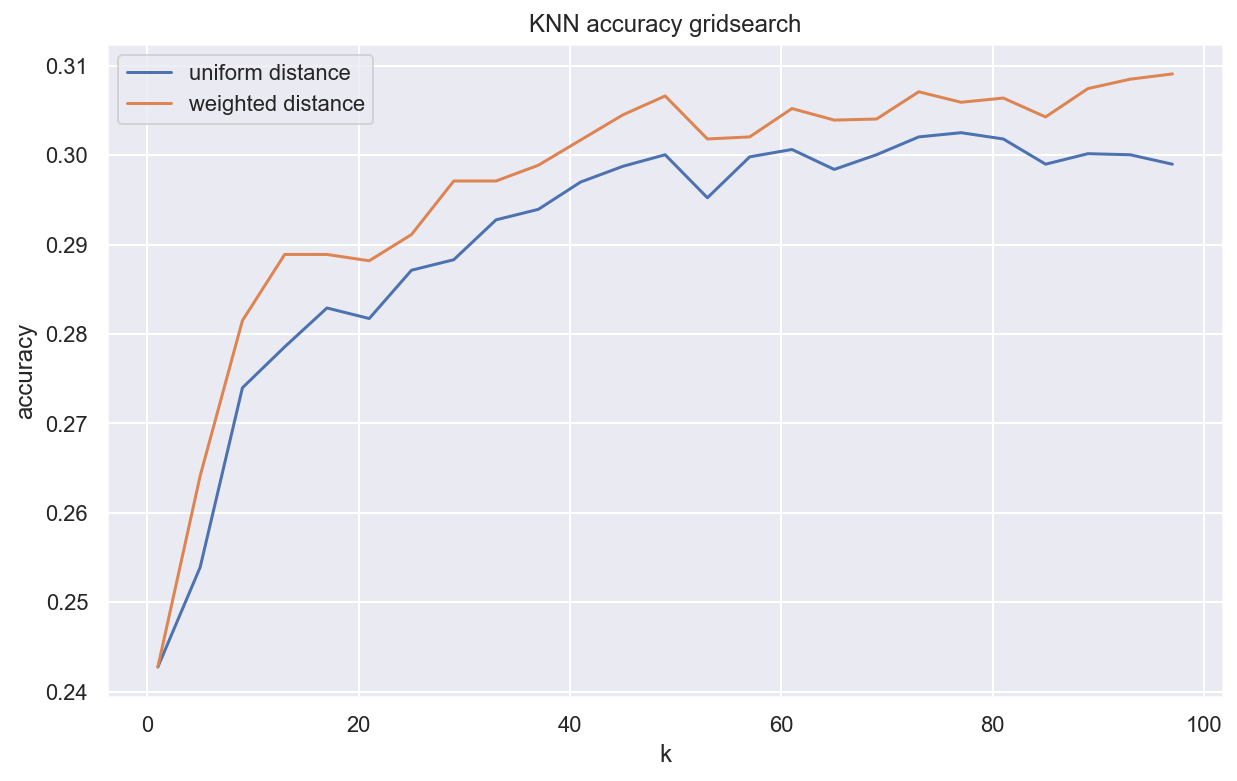

In [83]:
to_plot = pd.DataFrame([[knn_gscv.cv_results_['params'][i]['n_neighbors'],knn_gscv.cv_results_['params'][i]['weights'],knn_gscv.cv_results_['mean_test_score'][i]] for i in range(len(knn_gscv.cv_results_['mean_test_score']))])
plt.plot(to_plot[to_plot[1] == 'uniform'][0],to_plot[to_plot[1] == 'uniform'][2], label = 'uniform distance')
plt.plot(to_plot[to_plot[1] == 'distance'][0],to_plot[to_plot[1] == 'distance'][2], label = 'weighted distance')
plt.legend()
plt.title('KNN accuracy gridsearch')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

In [84]:
#check top performing n_neighbors value
print(knn_gscv.best_params_)

#check mean score for the top performing value of n_neighbors
print(knn_gscv.best_score_)

{'n_neighbors': 97, 'weights': 'distance'}
0.30910141617428816


In [85]:
print('Accuracy over test set: ', knn_gscv.best_estimator_.score(X_test,Y_test))
print('Accuracy over validation set: ', knn_gscv.best_estimator_.score(X_val,Y_val))
print(confusion_matrix(Y_test, knn_gscv.best_estimator_.predict(X_test)))

Accuracy over test set:  0.3031798245614035
Accuracy over validation set:  0.3046575342465753
[[  0   7  19   1   0  55]
 [  0  46  83  10   0 233]
 [  0  28 120   9   1 238]
 [  0  35  73  19   0 143]
 [  0  24  34   9   1 125]
 [  0  33 105   6   0 367]]


# Support Vector Machine

## RBF Kernel SVM

In [86]:
import time
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

c = [0.1,1,10,100,1000]
gamma = [0.001,0.01,0.1,1,10]

params_grid_ = dict(C = c, gamma = gamma)

SVM_grid = GridSearchCV(SVC(kernel='rbf'),
                        params_grid_,
                        cv = 5,
                        return_train_score = True,
                        n_jobs = -1)
SVM_grid.fit(X_train,Y_train)

print("Best accuracy achieved in CV: {0:.2f}".format(SVM_grid.best_score_))
print("Best choice of parameters {}".format(SVM_grid.best_params_))

Best_C_TFIDF = SVM_grid.best_params_['C']
Best_Gamma_TFIDF = SVM_grid.best_params_['gamma']

Best accuracy achieved in CV: 0.31
Best choice of parameters {'C': 10, 'gamma': 0.01}
Total time elapsed 247.97002387046814


#### RBF SVM Predictions


In [98]:
SVM_predict = SVM_grid.predict(X_test)

fit_time = time.time() 
test_SVM = SVM_grid.score(X_test, Y_test)
fit_time = time.time() - fit_time

print("Confussion Matrix")
print(confusion_matrix(Y_test, SVM_predict))
print("Accuracy: {0:.3f}".format(test_SVM))

Confussion Matrix
[[  0  14   0  63   0   5]
 [  0 107   0 202   0  63]
 [  0 136   0 189   0  71]
 [  0  87   0 141   0  42]
 [  0  23   0 139   0  31]
 [  0 100   0 365   0  46]]
Accuracy: 0.161


# Decision Tree classifier

In [96]:
from sklearn.tree import DecisionTreeClassifier


In [ ]:
# we now see that the tree does not explain anything it only takes the likes and retweets
# so we will repeat without them


In [94]:
#as our models are not performing very well (probably due to the nature of our data)
# the model that we are going to choose is a decision tree

## the reasons
# it wont perform as good (as bad really) as random forest or other 
# classification techniques that we already have tried
# BUT those techniques haven't work with a good performance so.
# The most important part of our proyect is interpretability and beaing able to extract knowledge from the data
# that is why a decision tree will serve us good
# it doesnt rely on scaling the data (so we can let untouched our likes and retweets and see 
# if they take part on the classification decision)
# and, if we dont do linearn combinations of our data (that means no PCA), 
# we will have rules that apply over likes, retweets and the probability values of our selected topics 
# returned by the LDA which are features that we know well how to interpret.
# a Decision tree's criterion for creating branches acts as an embedded feature selector 

#we will reload our data 
T_train = df_train['Main_topic']
Y_train = df_train['Mayor Parties']
X_train = np.array(df_train.drop(['Main_topic','Mayor Parties'],axis =1))


T_test = df_test['Main_topic']
Y_test = df_test['Mayor Parties']
X_test = np.array(df_test.drop(['Main_topic','Mayor Parties'],axis =1))

T_val = df_val['Main_topic']
Y_val = df_val['Mayor Parties']
X_val = np.array(df_val.drop(['Main_topic','Mayor Parties'],axis =1))

In [99]:
max_depth = range(2,14)
criterion = ['gini', 'entropy']
clf_GS = GridSearchCV(estimator = DecisionTreeClassifier(), 
                      param_grid = {'criterion':criterion,'max_depth':max_depth},
                      n_jobs = -1)
clf_GS.fit(X_train, Y_train)

print(clf_GS.best_score_)
print(clf_GS.best_params_)

tree_classifier = DecisionTreeClassifier(**clf_GS.best_params_).fit(X_train,Y_train)
print(f'Accuracy on trainset: {tree_classifier.score(X_train,Y_train)}')
print(f'Accuracy on testset: {tree_classifier.score(X_test,Y_test)}')

0.3404580152671756
{'criterion': 'entropy', 'max_depth': 5}
Accuracy on trainset: 0.35537287140340573
Accuracy on testset: 0.3196271929824561


In [28]:
print(export_text(tree_classifier, feature_names=list(final_df.columns[2:-2])))

|--- Likes <= 50.50
|   |--- Likes <= 2.50
|   |   |--- Retweets <= 1.50
|   |   |   |--- class: Other
|   |   |--- Retweets >  1.50
|   |   |   |--- class: PP
|   |--- Likes >  2.50
|   |   |--- Likes <= 17.50
|   |   |   |--- class: PP
|   |   |--- Likes >  17.50
|   |   |   |--- class: Vox
|--- Likes >  50.50
|   |--- Retweets <= 549.50
|   |   |--- Retweets <= 28.50
|   |   |   |--- class: Vox
|   |   |--- Retweets >  28.50
|   |   |   |--- class: Vox
|   |--- Retweets >  549.50
|   |   |--- Likes <= 2632.00
|   |   |   |--- class: Vox
|   |   |--- Likes >  2632.00
|   |   |   |--- class: Vox



In [29]:
max_depth = range(2,14)
criterion = ['gini', 'entropy']
clf_GS = GridSearchCV(
    estimator = DecisionTreeClassifier(), 
    param_grid = {'criterion':criterion,'max_depth':max_depth},
    n_jobs = -1
)
clf_GS.fit(X_train.iloc[:,:-2], Y_train)

print(clf_GS.best_score_)
print(clf_GS.best_params_)

tree_classifier = DecisionTreeClassifier(**clf_GS.best_params_).fit(X_train.iloc[:,:-2],Y_train)
print('Accuracy on trainset: ',tree_classifier.score(X_train.iloc[:,:-2],Y_train))
print('Accuracy on testset: ',tree_classifier.score(X_test.iloc[:,:-2],Y_test))

0.29844879458390144
{'criterion': 'entropy', 'max_depth': 2}
Accuracy on trainset:  0.3004976580796253
Accuracy on testset:  0.29049897470950103


In [30]:
print(export_text(tree_classifier, feature_names=list(final_df.columns[2:-4])))

|--- Congratulations and culture <= 0.06
|   |--- Evolution of the vaccination plan and pandemic situation <= 0.02
|   |   |--- class: Other
|   |--- Evolution of the vaccination plan and pandemic situation >  0.02
|   |   |--- class: Vox
|--- Congratulations and culture >  0.06
|   |--- Madrid elections (citizen participation) <= 0.06
|   |   |--- class: Vox
|   |--- Madrid elections (citizen participation) >  0.06
|   |   |--- class: Vox



In [ ]:
# We see that it only classifies for Vox and PSOE#

In [ ]:
# after all we conclude that due to the nature of our dataset, a classification task 
# of predicting to which party a tweet belongs is not an easy task and probably 
# not the most enlightening question to make.